In [424]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [425]:
df = pd.read_csv('./Data/House_Rent_Dataset.csv',parse_dates=['Posted On'])
df.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


In [646]:
df['Posted On'].agg(['max','min'])

max   2022-07-11
min   2022-04-13
Name: Posted On, dtype: datetime64[ns]

In [426]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Posted On          4746 non-null   datetime64[ns]
 1   BHK                4746 non-null   int64         
 2   Rent               4746 non-null   int64         
 3   Size               4746 non-null   int64         
 4   Floor              4746 non-null   object        
 5   Area Type          4746 non-null   object        
 6   Area Locality      4746 non-null   object        
 7   City               4746 non-null   object        
 8   Furnishing Status  4746 non-null   object        
 9   Tenant Preferred   4746 non-null   object        
 10  Bathroom           4746 non-null   int64         
 11  Point of Contact   4746 non-null   object        
dtypes: datetime64[ns](1), int64(4), object(7)
memory usage: 445.1+ KB


In [427]:
df.corr()['Rent']

BHK         0.369718
Rent        1.000000
Size        0.413551
Bathroom    0.441215
Name: Rent, dtype: float64

In [516]:
df.groupby('BHK')['Rent'].agg(['count','mean'])

,count,mean
BHK,,
1,1167,14139.223650
2,2265,22113.864018
3,1098,55863.062842
4,189,168864.555556
5,19,297500.000000
6,8,73125.000000


In [518]:
aggs

,count,mean
BHK,,
1,1167,14139.223650
2,2265,22113.864018
3,1098,55863.062842
4,189,168864.555556
5,19,297500.000000
6,8,73125.000000


Text(0.5, 0, 'Rent')

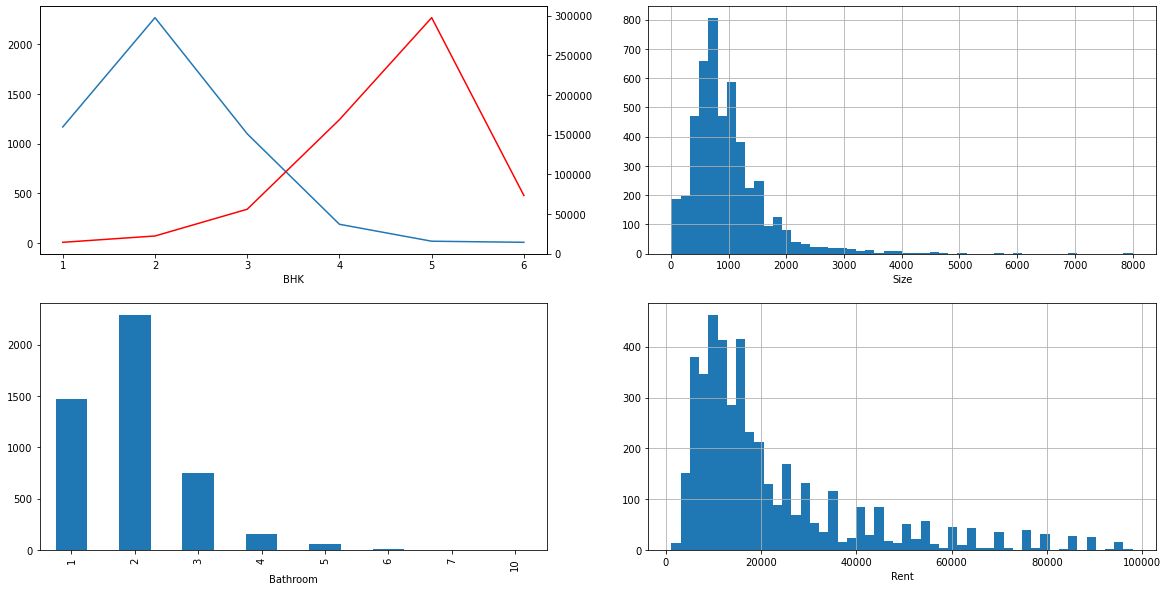

In [647]:
fig,axes = plt.subplots(2,2,figsize=[20,10])

aggs = df.groupby('BHK')['Rent'].agg(['count','mean'])
aggs['count'].plot(ax=axes[0,0])
aggs['mean'].plot(ax=axes[0,0].twinx(),c='r')

df['Size'].hist(ax=axes[0,1],bins=50)
axes[0,1].set_xlabel('Size')

df['Bathroom'].value_counts().sort_index().plot.bar(ax=axes[1,0])
axes[1,0].set_xlabel('Bathroom')

df[df['Rent']<100000]['Rent'].hist(bins=50,ax=axes[1,1])
axes[1,1].set_xlabel('Rent')

In [648]:
# Statsmodel version
import statsmodels.api as sm

class LinearRegressionSM:
    def __init__(self,X,y,*args,**kwargs):
        self.ols = sm.OLS(X,y,*args,**kwargs)
        self.ols_fitted = None
        
    def fit(self,*args,**kwargs):
        self.ols_fitted = self.ols.fit(*args,**kwargs)
        return self
    
    def predict(self,X,*args,**kwargs):
        return self.ols_fitted.predict(exog=X,*args,**kwargs)
    
    def predict_with_intervals(self,X):
        #yhat = self.predict(X).ravel()
        predictions = self.ols_fitted.get_prediction(exog=X)
        summary_frame = predictions.summary_frame(alpha=0.05)
        results = {
            'iv_l':summary_frame["obs_ci_lower"],
            'mean':summary_frame["mean"],
            'iv_u':summary_frame["obs_ci_upper"],
        }

        return results
    
    def summary(self,*args,**kwargs):
        return self.ols_fitted.summary()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Rent_yeo_johnson
Feature names seen at fit time, yet now missing:
- Rent

  warnings.warn(message, FutureWarning)


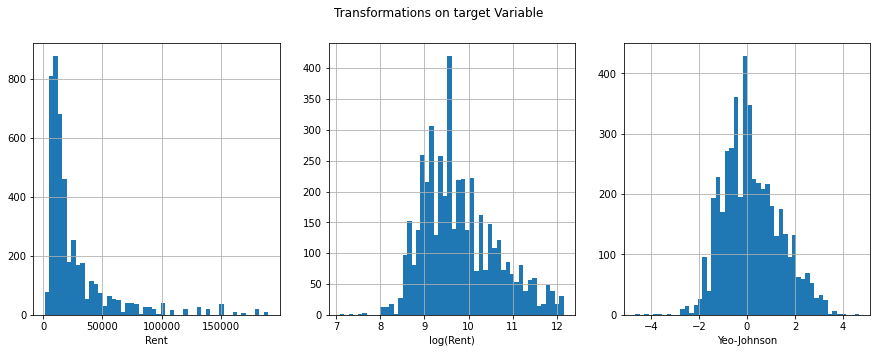

In [649]:
fig,axes = plt.subplots(1,3,figsize=[15,5])
df[df['Rent']<2*10**5]['Rent'].hist(bins=50,ax=axes[0])
axes[0].set_xlabel('Rent')

np.log(df[df['Rent']<2*10**5]['Rent']).hist(bins=50,ax=axes[1])
axes[1].set_xlabel('log(Rent)')

from sklearn.preprocessing import PowerTransformer
transformer = PowerTransformer(method='yeo-johnson',standardize=True)
transformer.fit_transform(df[df['Rent']<10**5][['Rent']])
df['Rent_yeo_johnson'] = transformer.transform(df[['Rent']])
df['inv_yeo_johnson_Rent'] = transformer.inverse_transform(df[['Rent_yeo_johnson']])
pd.Series(df['Rent_yeo_johnson']).hist(bins=50,ax=axes[2])
axes[2].set_xlabel('Yeo-Johnson')
plt.suptitle('Transformations on target Variable')
plt.show()

In [650]:
df['log_size'] = np.log(df['Size'])

In [651]:
from patsy import dmatrices

build_data = df[(df.Rent<10**6)&(df.Size<4000)]

y,X = dmatrices("Rent_yeo_johnson ~ log_size", build_data)

#import statsmodels.api as sm
ols = LinearRegressionSM(y, X)
model = ols.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Rent_yeo_johnson   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     1392.
Date:                Wed, 24 May 2023   Prob (F-statistic):          3.48e-267
Time:                        23:34:38   Log-Likelihood:                -6819.0
No. Observations:                4720   AIC:                         1.364e+04
Df Residuals:                    4718   BIC:                         1.365e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.1458      0.143    -35.941      0.000      -5.426      -4.865
log_size       0.7981      0.021     37.307      0.000       0.756       0.840
==============================================================================
Omnibus:                      144.909   Durbin-Watson:                   0.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              153.492
Skew:                           0.427   Prob(JB):                     4.67e-34
Kurtosis:                       2.775   Cond. No.                         65.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

ValueError: x and y must have same first dimension, but have shapes (1000,) and (4746,)

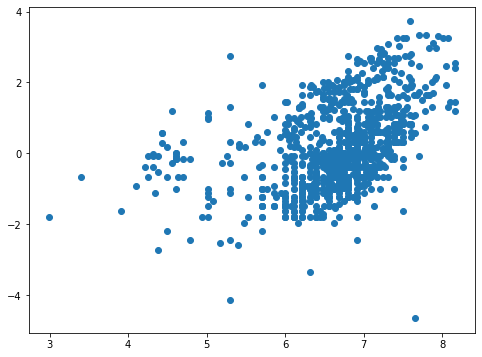

In [658]:
pred_ols = model.predict_with_intervals(X)
pred_ols
iv_l = pred_ols["iv_l"]
iv_u = pred_ols["iv_u"]
mean = pred_ols["mean"]

fig, ax = plt.subplots(figsize=(8, 6))

x = df[(df.Rent<10**6)&(df.Size<4000)]['log_size'].ravel()
y = df[(df.Rent<10**6)&(df.Size<4000)]['Rent_yeo_johnson'].ravel()
ax.plot(x,y, "o", label="data")
ax.plot(x, mean, "r--.", label="OLS")
ax.plot(x, iv_u, "k--")
ax.plot(x, iv_l, "k--")
ax.legend(loc="best")
plt.xlabel("Log Size")
plt.ylabel('Rent (yeo johnson transform)')
plt.show()

In [653]:
build_data['Area Type'].value_counts()

Super Area     2435
Carpet Area    2283
Built Area        2
Name: Area Type, dtype: int64

In [654]:
from sklearn.linear_model import LinearRegression
from patsy import dmatrices
reg = LinearRegression(fit_intercept=True)
df['log_Size'] = np.log(df['Size'])
build_data = df
build_data['BHK_cat'] = pd.Series(np.where(build_data['BHK']>5,5,build_data['BHK'])).map({1:"1",2:"1",3:"3",4:"4",5:"4"})
build_data['Furnishing_Status'] = build_data['Furnishing Status']
build_data['area_type'] = build_data['Area Type'].map({'Built Area':'Super Area',
                                                       'Super Area':'Super Area',
                                                       'Carpet Area':'Carpet Area'})

y,X = dmatrices("Rent_yeo_johnson ~ log_size + BHK_cat + Bathroom + City + Furnishing_Status + area_type", build_data)

ols = LinearRegressionSM(y, X)
model = ols.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Rent_yeo_johnson   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     1255.
Date:                Wed, 24 May 2023   Prob (F-statistic):               0.00
Time:                        23:34:39   Log-Likelihood:                -4132.4
No. Observations:                4746   AIC:                             8291.
Df Residuals:                    4733   BIC:                             8375.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -3.2336      0.107    -30.239      0.000      -3.443      -3.024
BHK_cat[T.3]                            0.3817      0.026     14.552      0.000       0.330       0.433
BHK_cat[T.4]                            0.4839      0.055      8.826      0.000       0.376       0.591
City[T.Chennai]                        -0.0822      0.028     -2.958      0.003      -0.137      -0.028
City[T.Delhi]                           0.4097      0.032     12.644      0.000       0.346       0.473
City[T.Hyderabad]                      -0.1876      0.028     -6.622      0.000      -0.243      -0.132
City[T.Kolkata]                        -0.4344      0.033    -13.107      0.000      -0.499      -0.369
City[T.Mumbai]                          1.2627      0.029     42.856      0.000       1.205       1.320
Furnishing_Status[T.Semi-Furnished]    -0.2140      0.026     -8.315      0.000      -0.264      -0.164
Furnishing_Status[T.Unfurnished]       -0.3786      0.027    -14.202      0.000      -0.431      -0.326
area_type[T.Super Area]                -0.2302      0.019    -12.343      0.000      -0.267      -0.194
log_size                                0.3996      0.016     24.386      0.000       0.367       0.432
Bathroom                                0.4029      0.016     24.788      0.000       0.371       0.435
==============================================================================
Omnibus:                      472.936   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3309.308
Skew:                          -0.183   Prob(JB):                         0.00
Kurtosis:                       7.075   Cond. No.                         94.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

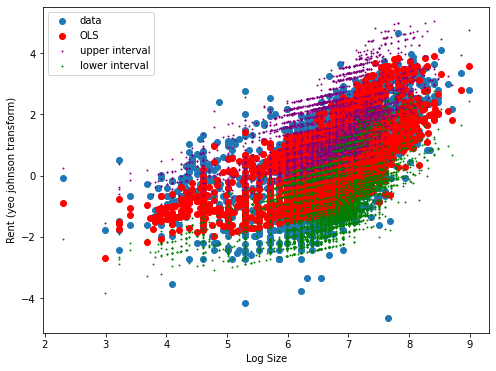

In [655]:
pred_ols = model.predict_with_intervals(X)
pred_ols
iv_l = pred_ols["iv_l"].values.ravel()
iv_u = pred_ols["iv_u"].values.ravel()
mean = pred_ols["mean"].values.ravel()

fig, ax = plt.subplots(figsize=(8, 6))

x = df['log_size'].ravel()
y = df['Rent_yeo_johnson'].ravel()
ax.scatter(x,y, label="data")
ax.scatter(x, mean, c="r", label="OLS")
ax.scatter(x, iv_u, c="purple",s=0.9,label='upper interval')
ax.scatter(x, iv_l, c="green",s=0.9,label='lower interval')
#ax.legend(loc="best")
plt.xlabel("Log Size")
plt.ylabel('Rent (yeo johnson transform)')
plt.legend()
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


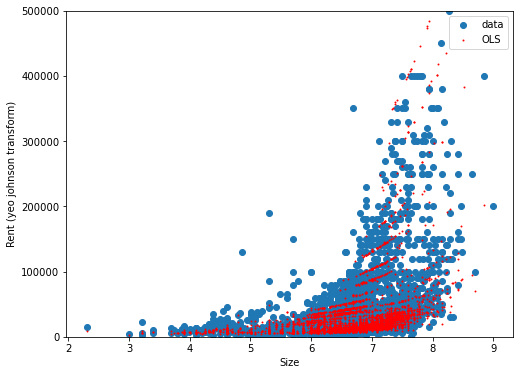

In [656]:
pred_ols = model.predict_with_intervals(X)
pred_ols
iv_l = transformer.inverse_transform(pred_ols["iv_l"].values.ravel().reshape(-1,1))
iv_u = transformer.inverse_transform(pred_ols["iv_u"].values.ravel().reshape(-1,1))
mean = transformer.inverse_transform(pred_ols["mean"].values.ravel().reshape(-1,1))

fig, ax = plt.subplots(figsize=(8, 6))

x = df['log_size'].ravel()
y = df['Rent'].ravel()
ax.scatter(x,y, label="data")
ax.scatter(x, mean, c="r", label="OLS",s=0.9)
#ax.scatter(x, iv_u, c="purple",s=0.9,label='upper interval')
#ax.scatter(x, iv_l, c="green",s=0.9,label='lower interval')
#ax.legend(loc="best")
plt.ylim(0,5*10**5)
plt.xlabel("Size")
plt.ylabel('Rent (yeo johnson transform)')
plt.legend()
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- iv_l
Feature names seen at fit time, yet now missing:
- Rent

  warnings.warn(message, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- mean
Feature names seen at fit time, yet now missing:
- Rent

  warnings.warn(message, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- iv_u
Feature names seen at fit time, yet now missing:
- Rent

  warnings.warn(message, FutureWarning)


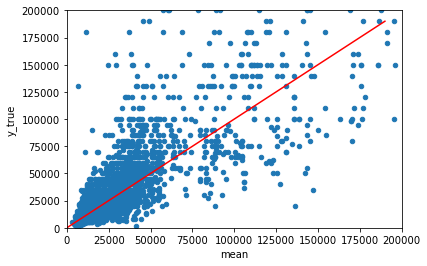

In [657]:
predictions = pd.DataFrame(pred_ols)
predictions['iv_l'] = transformer.inverse_transform(predictions[['iv_l']])
predictions['mean'] = transformer.inverse_transform(predictions[['mean']])
predictions['iv_u'] = transformer.inverse_transform(predictions[['iv_u']])
predictions['y_true'] = y
predictions.plot.scatter(x='mean',y='y_true')
plt.xlim(0,2*10**5)
plt.ylim(0,2*10**5)
x = np.arange(0,2*10**5,10**4)
plt.plot(x,x,c='r')

# Using Random Forest Regressor

In [642]:
from sklearn.ensemble import RandomForestRegressor

build_data = df
build_data['BHK_cat'] = pd.Series(np.where(build_data['BHK']>5,5,build_data['BHK'])).map({1:"1",2:"1",3:"3",4:"4",5:"4"})
build_data['Furnishing_Status'] = build_data['Furnishing Status']
build_data['area_type'] = build_data['Area Type'].map({'Built Area':'Super Area',
                                                       'Super Area':'Super Area',
                                                       'Carpet Area':'Carpet Area'})

y,X = dmatrices("Rent ~ log_size + BHK_cat + Bathroom + City + Furnishing_Status + area_type", build_data)

/var/folders/zz/6qmw063d657221m69g8htslc0000gn/T/ipykernel_9830/3765337905.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(X,y)


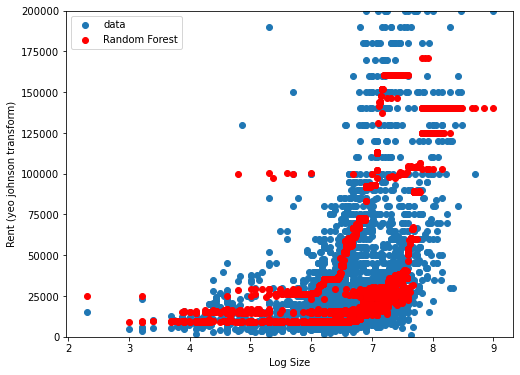

In [643]:
reg = RandomForestRegressor(n_estimators=20,max_depth=5,min_samples_leaf=50)
reg.fit(X,y)

# pred_ols = model.predict_with_intervals(X)
# pred_ols
# iv_l = pred_ols["iv_l"].values.ravel()
# iv_u = pred_ols["iv_u"].values.ravel()
mean = reg.predict(X)

fig, ax = plt.subplots(figsize=(8, 6))

x = df['log_size'].ravel()
y = df['Rent'].ravel()
ax.scatter(x,y, label="data")
ax.scatter(x, mean, c="r", label="Random Forest")
#ax.scatter(x, iv_u, c="purple",s=0.9,label='upper interval')
#ax.scatter(x, iv_l, c="green",s=0.9,label='lower interval')
#ax.legend(loc="best")
plt.xlabel("Log Size")
plt.ylabel('Rent (yeo johnson transform)')
plt.ylim(0,2*10**5)
plt.legend()
plt.show()

In [605]:
from sklearn.linear_model import LinearRegression
from patsy import dmatrices
reg = LinearRegression(fit_intercept=True)
df['log_Size'] = np.log(df['Size'])
build_data = df
build_data['BHK_cat'] = pd.Series(np.where(build_data['BHK']>5,5,build_data['BHK'])).map({1:"1",2:"1",3:"3",4:"4",5:"4"})
build_data['Furnishing_Status'] = build_data['Furnishing Status']
build_data['area_type'] = build_data['Area Type'].map({'Built Area':'Super Area',
                                                       'Super Area':'Super Area',
                                                       'Carpet Area':'Carpet Area'})

y,X = dmatrices("Rent_yeo_johnson ~ log_size + BHK", build_data)

In [622]:
from pygam import LinearGAM, s, f,GAM

gam = GAM( s(1) +s(2)).fit(np.asarray(X), np.asarray(y))

/opt/anaconda3/lib/python3.9/site-packages/pygam/pygam.py:802: RuntimeWarning: invalid value encountered in reciprocal
  np.fill_diagonal(Dinv, d**-1)  # invert the singular values


In [623]:
gam.summary()

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     18.6358
Link Function:                     IdentityLink Log Likelihood:                                  -6339.327
Number of Samples:                         4746 AIC:                                            12717.9257
                                                AICc:                                           12718.0972
                                                GCV:                                                0.8423
                                                Scale:                                              0.8364
                                                Pseudo R-Squared:                                   0.4036
Feature Function                  Lam

/var/folders/zz/6qmw063d657221m69g8htslc0000gn/T/ipykernel_9830/3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


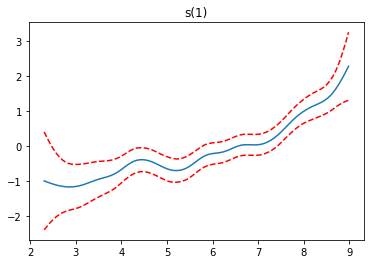

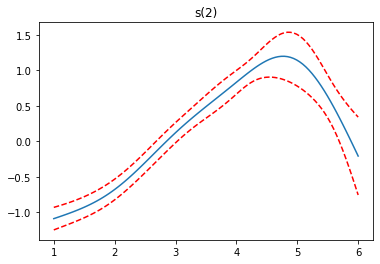

In [624]:

for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()